In [1]:
import numpy as np
import torch
import pickle

def concat_tens(tensors, tens_ind=0):
    tensors = [tensor.numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in tensors[tens_ind]]
    # Concatenate directly
    tensors = np.concatenate(tensors, axis=0)
    return tensors

def expected_normalised_calibration_error(predictions, target_values, uncertainties, M=10):
    
    # Take the square root of the uncertainties to obtain standard deviations 
    stdevs = np.sqrt(uncertainties)

    # Create an array of the errors
    errors = predictions - target_values

    # Sort the arrays on increasing standard deviation (σ) 
    sorted_indices = np.argsort(stdevs)
    sorted_stdevs = stdevs[sorted_indices]
    sorted_errors = errors[sorted_indices]

    n_samples = len(predictions)

    bin_edges = np.linspace(0, n_samples, M + 1).astype(int)
   
    ENCE = 0
    MSEs = []
    MVs = []
    bin_sizes = []

    for i in range(M):
        bin_lower, bin_upper = bin_edges[i], bin_edges[i + 1]

        bin_stdevs = sorted_stdevs[bin_lower:bin_upper]
        bin_errors = sorted_errors[bin_lower:bin_upper]

        bin_sizes.append(len(bin_errors))

        bin_vars = (bin_stdevs)**2

        bin_MV = bin_vars.mean()
        bin_MSE = ( (bin_errors) ** 2).mean()

        MSEs.append(bin_MSE)
        MVs.append(bin_MV)

        ENCE += np.abs(np.sqrt(bin_MV) - np.sqrt(bin_MSE)) / (np.sqrt(bin_MV))

    ENCE = ENCE/M

    return ENCE, MSEs, MVs, bin_sizes

In [2]:

# Load the pickle file
with open('test_targs_cpu.pkl', 'rb') as file:
    targs = pickle.load(file)
targs = concat_tens(targs,0)

In [3]:
sbp_targs = []
dbp_targs = []
for i in targs:
    sbp_targs.append(i[0])
    dbp_targs.append(i[1])
sbp_targs = np.array(sbp_targs)
dbp_targs = np.array(dbp_targs)

In [4]:

# Load the pickle file
with open('test_preds_cpu.pkl', 'rb') as file:
    preds = pickle.load(file)

preds = concat_tens(preds,0)

sbp_preds = []
dbp_preds = []
for i in preds:
    sbp_preds.append(i[0])
    dbp_preds.append(i[2])

sbp_preds = np.array(sbp_preds)
dbp_preds = np.array(dbp_preds)

In [5]:
# Load the pickle file
with open('test_epi_sbp.pkl', 'rb') as file:
    data = pickle.load(file)

epi = concat_tens(data,0)

# Load the pickle file
with open('test_ale_sbp.pkl', 'rb') as file:
    data = pickle.load(file)

ale = concat_tens(data,0)

total_sbp = ale+epi

In [6]:
# Load the pickle file
with open('test_epi_dbp.pkl', 'rb') as file:
    data = pickle.load(file)

epi = concat_tens(data,0)

# Load the pickle file
with open('test_ale_dbp.pkl', 'rb') as file:
    data = pickle.load(file)

ale = concat_tens(data,0)

total_dbp = ale+epi

In [7]:
ENCE_sbp, MSEs_sbp, MVs_sbp, bin_sizes_sbp = expected_normalised_calibration_error(sbp_preds, sbp_targs, total_sbp, M=10)

In [8]:
ENCE_dbp, MSEs_dbp, MVs_dbp, bin_sizes_dbp = expected_normalised_calibration_error(dbp_preds, dbp_targs, total_dbp, M=10)

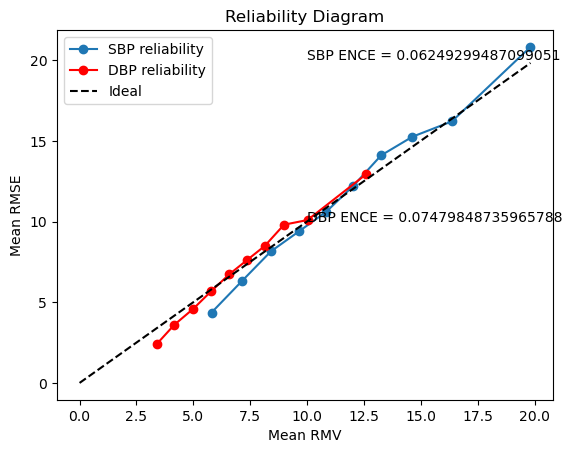

In [9]:
import matplotlib.pyplot as plt
plt.title('Reliability Diagram')
plt.xlabel('Mean RMV')
plt.ylabel('Mean RMSE')
plt.plot(np.array(MVs_sbp)**.5, np.array(MSEs_sbp)**.5, 'o-', label = 'SBP reliability')  # Plot data with markers and solid line
plt.plot(np.array(MVs_dbp)**.5, np.array(MSEs_dbp)**.5, 'ro-', label = 'DBP reliability')  # Plot data with markers and solid line

# Plot the linear slope (y=x) as a dashed line
plt.plot([0, max(np.array(MVs_sbp)**.5)], [0, max(np.array(MVs_sbp)**.5)], 'k--', label='Ideal')  # Dashed line for linear slope
# Add text annotation
plt.text(10, 20, f'SBP ENCE = {ENCE_sbp}')
plt.text(10, 10, f'DBP ENCE = {ENCE_dbp}')
plt.legend()
# Show plot
plt.show()

# MAE

In [10]:
print('SBP MAE = ' + str(np.mean(np.abs((sbp_preds - sbp_targs)))))

SBP MAE = 9.063861


In [11]:
print('DBP MAE = ' + str(np.mean(np.abs((dbp_preds - dbp_targs)))))

DBP MAE = 5.511723
